Ray module reloaded
Generating 4004001 rays...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..485].


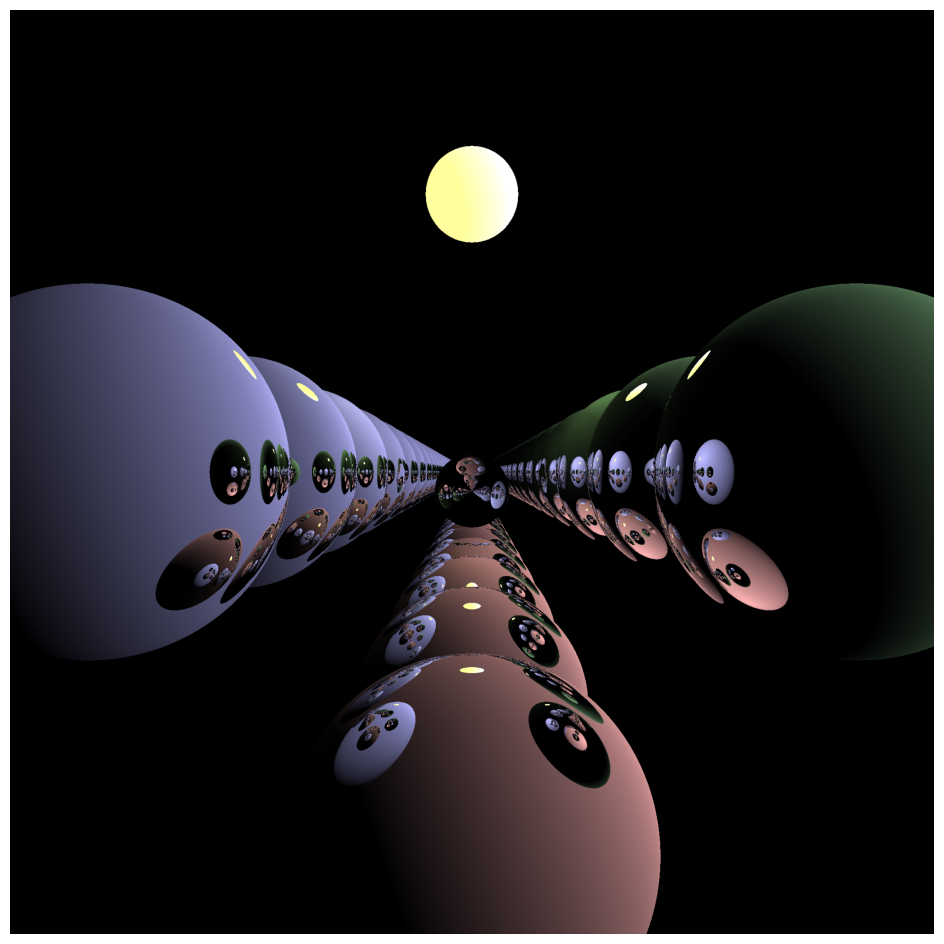

In [ ]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from vector import Vector
from object import Sphere
from ray import Ray, Intersection
from material import Material
from colour import Colour
from light import GlobalLight, PointLight


base_material = Material()
emitive_material = Material(emitive=True)
reflective_material = Material(reflective=True)
glass = Material(reflective=False, transparent=True, refractive_index=2)

# create a bunch of spheres to render
spheres = []
glowing_sphere = Sphere(
    id=0,
    centre=Vector(0, 3, -5),
    radius=0.5,
    material=emitive_material,
    colour=Colour(255, 255, 200)
)
# glowing light sphere at top of tunnel
spheres.append(glowing_sphere)

# Create a corridor of reflective spheres
id_counter = 1
for z in range(0, 80, 3):
    # left wall
    spheres.append(Sphere(
        id=id_counter,
        centre=Vector(-2, 0, -z),
        radius=1,
        material=reflective_material,
        colour=Colour(180, 180, 255)
    ))
    id_counter += 1
    
    # right wall
    spheres.append(Sphere(
        id=id_counter,
        centre=Vector(2, 0, -z),
        radius=1,
        material=reflective_material,
        colour=Colour(180, 255, 180)
    ))
    id_counter += 1
    
    # floor
    spheres.append(Sphere(
        id=id_counter,
        centre=Vector(0, -2, -z),
        radius=1,
        material=reflective_material,
        colour=Colour(255, 180, 180)
    ))
    id_counter += 1

# add a glass marble floating mid-corridor
spheres.append(Sphere(
    id=id_counter,
    centre=Vector(0, -0.3, -10),
    radius=0.6,
    material=glass,
    colour=Colour(200, 200, 255)
))

point_light_sources = []
point_light_sources.append(PointLight(id=glowing_sphere.id, position=glowing_sphere.centre, colour=glowing_sphere.colour, strength=1, max_angle=np.radians(90), func=0))

global_light_sources = []
global_light_sources.append(GlobalLight(vector=Vector(3, 1, -0.75), colour=Colour(255, 255, 255), strength=1, max_angle=np.radians(120), func=0))


# sets up where the camera is
ray_origin = Vector(0, 0, 5)
rays = []

"""
Generate a pixel grid of rays.
"""
RAY_COUNT = 100  
RAY_STEP = 0.005   

multiple = 10    
RAY_COUNT *= multiple
RAY_STEP /= multiple

X_RAYS = [r*RAY_STEP for r in range(-RAY_COUNT, 0, 1)] + [r*RAY_STEP for r in range(0, RAY_COUNT + 1)]
Y_RAYS = [r*RAY_STEP for r in range(RAY_COUNT, 0, -1)] + [-r*RAY_STEP for r in range(0, RAY_COUNT + 1)]
Z = -1

MAX_BOUNCES = 10

TOTAL_RAYS = len(X_RAYS) * len(Y_RAYS)

print(f"Generating {TOTAL_RAYS} rays...")
for Y in Y_RAYS:
    for X in X_RAYS:
        ray = Ray(
            origin=ray_origin,
            D=Vector(x=X, y=Y, z=-1)
        )
        rays.append(ray)

max_angle = np.radians(90)
background_colour = Colour(0, 0, 1)
black_colour = Colour(0, 0, 1)
sky_colour = Colour(20,0,200)

pixels = []

progress_milestones = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
"""
For each ray, find its nearest intersection and set the pixel color accordingly
"""
for i, ray in enumerate(rays):

    progress = (i+1) / len(rays) * 100
    if progress > progress_milestones[0]:
        progress_milestones.pop(0)
        print(f"Casting Rays: {progress:.0f}%", end="\r")

    
    ray_terminal = ray.nearestSphereIntersect(spheres, max_bounces=MAX_BOUNCES)

    if ray_terminal == None:
        pixels.append(sky_colour.getList())

    else:
        pixels.append(ray_terminal.terminalRGB(
            spheres=spheres,
            background_colour=background_colour,
            global_light_sources=global_light_sources,
            point_light_sources=point_light_sources
        ).getList())

X_SIZE = len(X_RAYS)
Y_SIZE = len(Y_RAYS)

pixels = np.array(pixels).reshape((X_SIZE, Y_SIZE, 3))

plt.figure(figsize=(12, 12))  
plt.imshow(pixels)
plt.axis('off')
plt.savefig('refraction_output.png', bbox_inches='tight')
plt.show()